Load the data set

In [ ]:
import pandas as pd
import re
import nltk
import string
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

Βήμα 1: Φόρτωση και Εξέταση Δεδομένων 

In [148]:
dataset = pd.read_excel("new_labeled_dataset_withNOs.xlsx", engine="openpyxl")
print("Πρώτες γραμμές του dataset:")
print(dataset.head())
print("\nΠληροφορίες του dataset:")
print(dataset.info())
print("\nΑριθμός κενών τιμών ανά στήλη:")
print(dataset.isnull().sum())

Πρώτες γραμμές του dataset:
                                                text  class_label
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...  hate_speech
1                                       Στα τέσσερα.           no
2                                 Στα τέσσερα εσείς.           no
3                                       Στα τέσσερα.           no
4                                            Λοιπόν.           no

Πληροφορίες του dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         866 non-null    object
 1   class_label  866 non-null    object
dtypes: object(2)
memory usage: 13.7+ KB
None

Αριθμός κενών τιμών ανά στήλη:
text           0
class_label    0
dtype: int64


Βήμα 2: Καθαρισμός Κειμένου

In [149]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Αφαίρεση σημείων στίξης
    text = re.sub(r'\d+', '', text)      # Αφαίρεση αριθμών
    return text

dataset['cleaned_text'] = dataset['text'].apply(clean_text)
print("\nΠαραδείγματα καθαρισμένου κειμένου:")
print(dataset[['text', 'cleaned_text']].head())


Παραδείγματα καθαρισμένου κειμένου:
                                                text  \
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...   
1                                       Στα τέσσερα.   
2                                 Στα τέσσερα εσείς.   
3                                       Στα τέσσερα.   
4                                            Λοιπόν.   

                                        cleaned_text  
0  μιας πρότασης  σελίδων η οποία δεν έγινε χωρίς...  
1                                        στα τέσσερα  
2                                  στα τέσσερα εσείς  
3                                        στα τέσσερα  
4                                             λοιπόν  


Exploratory Data Analysis

Κατανομή κλάσεων:
no             736
racism          52
irony           46
hate_speech     17
sexism          15
Name: class_label, dtype: int64


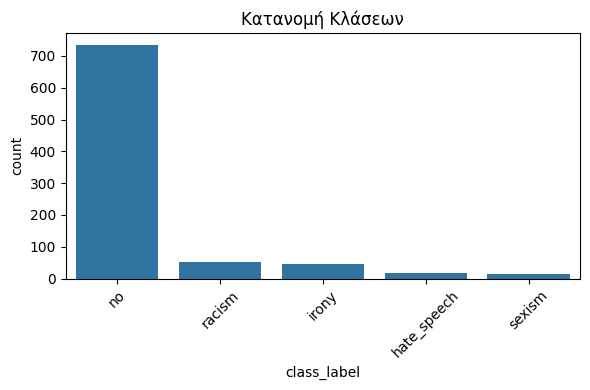


Στατιστικά μήκους κειμένου:
count    866.000000
mean       9.942263
std        8.717739
min        1.000000
25%        4.000000
50%        7.000000
75%       13.000000
max       68.000000
Name: text_length, dtype: float64


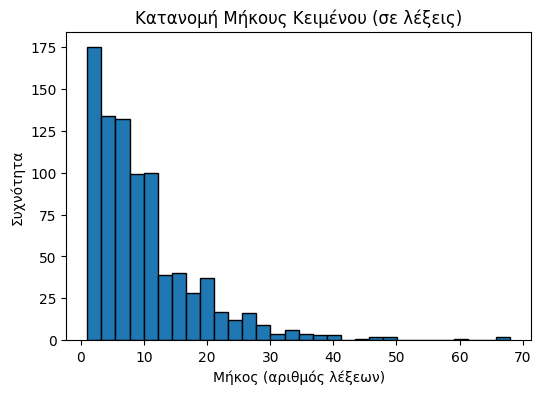


Οι 20 πιο συχνές λέξεις:
[('να', 322), ('και', 260), ('το', 244), ('δεν', 235), ('είναι', 198), ('που', 152), ('θα', 116), ('η', 109), ('με', 108), ('την', 106), ('τα', 101), ('αυτό', 95), ('ότι', 95), ('για', 90), ('ο', 85), ('εγώ', 75), ('της', 74), ('σε', 73), ('μου', 73), ('από', 69)]


[nltk_data] Downloading package punkt to /Users/annatolia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/annatolia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


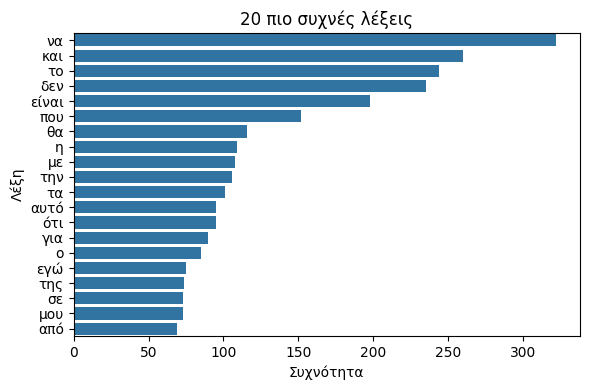

In [150]:
#Κατανομή κλάσης (Class Distribution)
print("Κατανομή κλάσεων:")
print(dataset['class_label'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(data=dataset, x='class_label', order=dataset['class_label'].value_counts().index)
plt.title("Κατανομή Κλάσεων")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Μήκος κειμένου (π.χ. αριθμός λέξεων)
dataset['text_length'] = dataset['cleaned_text'].apply(lambda x: len(x.split()))
print("\nΣτατιστικά μήκους κειμένου:")
print(dataset['text_length'].describe())

plt.figure(figsize=(6, 4))
plt.hist(dataset['text_length'], bins=30, edgecolor='black')
plt.title("Κατανομή Μήκους Κειμένου (σε λέξεις)")
plt.xlabel("Μήκος (αριθμός λέξεων)")
plt.ylabel("Συχνότητα")
plt.show()

# Συχνότητα λέξεων
# Tokenization στο cleaned_text (εάν το θες για ανάλυση συχνότητας)
# Κατέβασμα απαραίτητων πόρων του nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt', quiet=True)
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

all_tokens = [word for row in dataset['tokens'] for word in row]
counter = Counter(all_tokens)
print("\nΟι 20 πιο συχνές λέξεις:")
print(counter.most_common(20))

# Προαιρετικά, μπορείς να φτιάξεις και ένα απλό barplot για τις πιο συχνές λέξεις:
common_words = counter.most_common(20)
words, freqs = zip(*common_words)
plt.figure(figsize=(6, 4))
sns.barplot(x=list(freqs), y=list(words))
plt.title("20 πιο συχνές λέξεις")
plt.xlabel("Συχνότητα")
plt.ylabel("Λέξη")
plt.tight_layout()
plt.show()

Βήμα 3: Tokenization και Εφαρμογή Stopwords 

In [151]:
# Χρησιμοποίησε το καθαρισμένο κείμενο για tokenization
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

# (Προαιρετικά) Αφαίρεση πιθανών υπολειπόμενων σημείων στίξης ή αριθμών
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in string.punctuation and not word.isdigit()]
)

# Ορισμός και προσαρμογή λίστας stopwords στα Ελληνικά
default_stopwords = set(stopwords.words('greek'))
extra_stopwords = {
    'να', 'και', 'το', 'είναι', 'δεν', 'που', 'την', 'με', 'θα', 'η', 'τα', 'ότι', 'για',
    'μου', 'της', 'αυτό', 'σε', 'από', 'ο', 'Δεν', 'τη', 'τον', 'οι', 'του', 'στην', 'τους',
    'ένα', 'μας', 'στο', 'εγώ', 'έχει', 'σας', 'Και', 'σου', 'τώρα', 'μια', 'Εγώ', 'γιατί',
    'των', 'τι', 'αν', 'αυτή', 'πολύ', 'Να', 'κάτι', 'αυτά', 'Είναι'
}
custom_stopwords = default_stopwords - {"αυτός", "αυτή", "αυτοί"}
custom_stopwords.update(extra_stopwords)

# Ορισμός σημαντικών λέξεων που θέλουμε να κρατήσουμε
important_words = {"ρατσισμός", "σεξισμός", "ξενοφοβία", "κατά", "δικαιώματα", "προσβολή", "διάκριση",
                   "γυναίκα", "άντρας", "μαύρος", "λευκός", "ξένος", "αλλοδαπός"}
custom_stopwords = {word for word in custom_stopwords if word not in important_words}

print("\nΤελική λίστα stopwords:")
print(custom_stopwords)

# Αφαίρεση stopwords από τα tokens
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in custom_stopwords]
)

print("\nΠαραδείγματα tokens μετά την εφαρμογή stopwords:")
print(dataset[['cleaned_text', 'tokens']].head())


Τελική λίστα stopwords:
{'οἳ', 'πως', 'ὥς', 'δαίσ', 'γάρ', 'η', 'γε', 'εἴτε', 'τισ', 'στο', 'τις', 'οτι', 'επι', 'ἐπί', 'αυτή', 'ἅμα', 'τοῖς', "ἀλλ'", 'δεν', 'το', 'ὅθεν', 'ἄρα', 'και', 'αυτοσ', 'κάτι', 'ᾧ', 'αυτη', 'αὐτόσ', 'μετά', 'οὕτω', 'οὗτος', 'ένα', 'δαί', 'ὅτε', 'ἐπὶ', 'τήν', 'εἰσ', 'τῷ', 'οὐχ', 'ἤ', 'εἰς', 'ὅτι', 'αλλα', 'ὑπέρ', 'θα', 'ὅδε', 'ἐξ', 'οὐδ', 'τοῦ', 'οἱ', 'ωσ', 'σὺ', 'οι', 'ἐφ', 'γα', 'ἐγὼ', 'μα', 'ἣ', 'ταῖς', 'προ', 'μας', 'παρὰ', 'στη', 'στον', 'μια', 'μη', 'περί', 'αυτουσ', 'ποτε', 'εἴμι', 'ἐκ', 'γοῦν', 'τοὺς', 'γὰρ', 'διά', 'τούσ', 'ειναι', 'πωσ', 'εισαι', 'ὃν', 'πρόσ', 'Δεν', 'ἀπό', 'τους', 'κἂν', 'ὑπὲρ', 'τὸ', 'ὑπ', 'ἐὰν', 'εκεινα', 'από', 'ὅπερ', 'εἰμὶ', 'της', 'πρὸς', 'ἧς', 'αυτο', 'οὐκ', 'σας', 'εκεινη', 'ισωσ', 'τῶν', 'ἐμόσ', 'ὅς', 'δὲ', 'ἐν', 'ἔτι', 'ὃ', 'αὖ', 'τε', 'καὶ', 'ὡς', 'δαὶ', 'κατὰ', 'οὔτε', 'τὸν', 'αυτό', 'τησ', 'ἀπὸ', 'μὴν', 'ἐγώ', 'κἀν', 'ποιο', 'καί', 'μέν', 'ὅσ', 'προσ', 'ἐπεὶ', 'εκεινο', 'αἳ', 'ειμαι', 'τό', 'των', 'του', 'εκεινων', 'ἀφ'

Βήμα 4: Undersampling της Κλάσης "no" 

In [152]:
# Εμφάνιση κατανομής κλάσεων πριν το undersampling
print("\nΚατανομή κλάσεων πριν το undersampling:")
print(dataset['class_label'].value_counts())

# Διαχωρισμός των δεδομένων για την κλάση "no" και τις υπόλοιπες κλάσεις
dataset_no = dataset[dataset['class_label'] == 'no']
dataset_other = dataset[dataset['class_label'] != 'no']

# Επιλογή 60 τυχαίων δειγμάτων από την κλάση "no"
dataset_no_sampled = dataset_no.sample(n=60, random_state=42)

# Ενοποίηση με τα δείγματα των υπόλοιπων κλάσεων
dataset_balanced = pd.concat([dataset_no_sampled, dataset_other]).reset_index(drop=True)
print("\nΚατανομή κλάσεων μετά το undersampling:")
print(dataset_balanced['class_label'].value_counts())


Κατανομή κλάσεων πριν το undersampling:
no             736
racism          52
irony           46
hate_speech     17
sexism          15
Name: class_label, dtype: int64

Κατανομή κλάσεων μετά το undersampling:
no             60
racism         52
irony          46
hate_speech    17
sexism         15
Name: class_label, dtype: int64


Βήμα 5: Προετοιμασία Κειμένου για TF-IDF 

In [153]:
# Ενώνουμε τα tokens για κάθε δείγμα ώστε να δημιουργήσουμε το κείμενο για το TF-IDF
dataset_balanced['processed_text'] = dataset_balanced['tokens'].apply(lambda tokens: ' '.join(tokens))



Βήμα 6: Μετατροπή σε Χαρακτηριστικά με TF-IDF 

In [186]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(dataset_balanced['processed_text'])
y = dataset_balanced['class_label']

print("\nΜορφή του TF-IDF Feature Matrix:", X.shape)


Μορφή του TF-IDF Feature Matrix: (190, 920)


↑ 866 δειγματα (οσες οι γραμμες του dataset)
2207 features που διατηρηθηκαν

Naïve Bayes με LOO-CV
🔹 2️⃣ Τι Διαφορετικό Έχει ο Naïve Bayes;
✅ Προσαρμόζεται καλά σε text classification (σε αντίθεση με το Logistic Regression).
✅ Χρησιμοποιεί πιθανότητες λέξεων για να βρει τις πιο σχετικές κατηγορίες.
✅ Γενικά λειτουργεί καλά σε μικρά datasets, όπως το δικό σου.

NAIVE BASE - SMOTE

In [161]:
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np

# Αρχικοποίηση SMOTE για oversampling των λιγότερο εκπροσωπούμενων κατηγοριών
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Έλεγχος της νέας κατανομής των κατηγοριών
print("New class distribution:", Counter(y_resampled))

# Αρχικοποίηση Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Δημιουργία μοντέλου Naïve Bayes
model = MultinomialNB()

# Υπολογισμός ακρίβειας με LOO-CV
scores = cross_val_score(model, X_resampled, y_resampled, cv=loo, scoring='accuracy')
print(f"Μέση Ακρίβεια (Naïve Bayes με SMOTE - LOO-CV): {np.mean(scores):.4f}")

# --- Υπολογισμός Classification Report ---
Y_true = []
Y_pred = []

for train_index, test_index in loo.split(X_resampled):  
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]  # Χρήση slicing αντί για iloc
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]  # Pandas Series

    model.fit(X_train, y_train)  # Εκπαίδευση μοντέλου
    y_pred = model.predict(X_test)  # Πρόβλεψη

    Y_true.append(y_test.values[0])  # Μετατροπή σε απλή τιμή
    Y_pred.append(y_pred[0])  # Πρόβλεψη (NumPy array)

# Classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)


/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


New class distribution: Counter({'no': 60, 'hate_speech': 60, 'irony': 60, 'racism': 60, 'sexism': 60})
Μέση Ακρίβεια (Naïve Bayes με SMOTE - LOO-CV): 0.7033
              precision    recall  f1-score   support

      racism       0.65      0.97      0.78        60
      sexism       0.79      0.55      0.65        60
       irony       0.56      0.32      0.40        60
 hate_speech       0.77      0.68      0.73        60
          no       0.73      1.00      0.85        60

    accuracy                           0.70       300
   macro avg       0.70      0.70      0.68       300
weighted avg       0.70      0.70      0.68       300



CONFUSION MATRIX - NAIVE BASE SMOTE

Confusion Matrix:
[[58  0  0  1  1]
 [ 7 33  8  6  6]
 [18  7 19  5 11]
 [ 6  2  7 41  4]
 [ 0  0  0  0 60]]


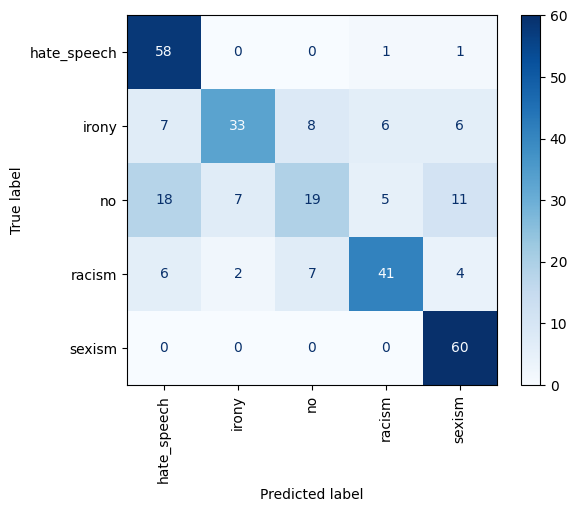

In [163]:

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Οπτικοποίηση του confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

NAIVE BASE - NO SMOTE

In [165]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import classification_report
import numpy as np

# Αρχικοποίηση Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Δημιουργία μοντέλου Naïve Bayes
model = MultinomialNB()

# Υπολογισμός ακρίβειας με LOO-CV
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"Μέση Ακρίβεια (Naïve Bayes - LOO-CV): {np.mean(scores):.4f}")

# --- Υπολογισμός Classification Report ---
Y_true = []
Y_pred = []

for train_index, test_index in loo.split(X):  
    X_train, X_test = X[train_index], X[test_index]  # Χρήση slicing αντί για iloc
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Pandas Series

    model.fit(X_train, y_train)  # Εκπαίδευση μοντέλου
    y_pred = model.predict(X_test)  # Πρόβλεψη

    Y_true.append(y_test.values[0])  # Μετατροπή σε απλή τιμή
    Y_pred.append(y_pred[0])  # Πρόβλεψη (NumPy array)

# Classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)


Μέση Ακρίβεια (Naïve Bayes - LOO-CV): 0.4000
              precision    recall  f1-score   support

      racism       0.00      0.00      0.00        17
      sexism       0.18      0.04      0.07        46
       irony       0.36      0.78      0.49        60
 hate_speech       0.56      0.52      0.54        52
          no       0.00      0.00      0.00        15

    accuracy                           0.40       190
   macro avg       0.22      0.27      0.22       190
weighted avg       0.31      0.40      0.32       190



/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

CONFUSION MATRIX - NAIVE BASE NO SMOTE

Confusion Matrix:
[[ 0  1 14  2  0]
 [ 0  2 34 10  0]
 [ 0  4 47  9  0]
 [ 0  4 21 27  0]
 [ 0  0 15  0  0]]


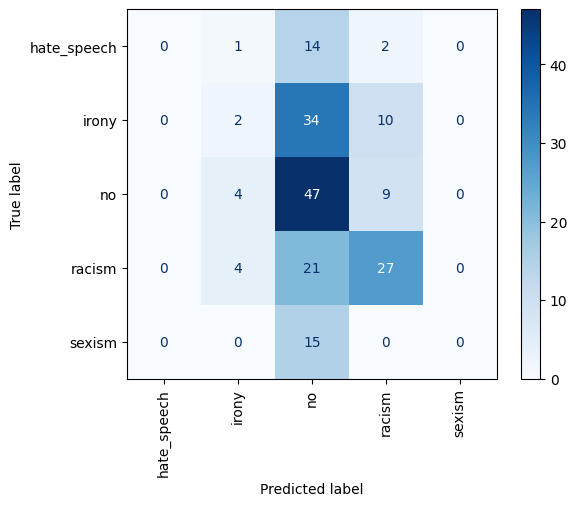

In [166]:

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Οπτικοποίηση του confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

Leave-One-Out Cross-Validation (LOO-CV) 
αντί για :
Split the data into Training and Testing
λόγω λίγων δειγμάτων

Κάθε φορά, κρατάμε 1 δείγμα για testing και εκπαιδεύουμε το μοντέλο με τα υπόλοιπα.
Επαναλαμβάνουμε για κάθε δείγμα στο dataset.
Έτσι, χρησιμοποιούμε όλο το dataset για εκπαίδευση και αποφεύγουμε τη σπατάλη δεδομένων.

Evaluate the model με LOGISTIC REGRESSION - NO SMOTE

In [168]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

# Αρχικοποίηση Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Δημιουργία Logistic Regression μοντέλου
model = LogisticRegression(max_iter=1000)

# Υπολογισμός μέσης ακρίβειας
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"Μέση Ακρίβεια (LOO-CV): {np.mean(scores):.4f}")

# --- Νέος Κώδικας για classification_report ---
Y_true = []
Y_pred = []

for train_index, test_index in loo.split(X):  
    X_train, X_test = X[train_index], X[test_index]  # ✅ Χρήση slicing αντί για iloc
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # ✅ Μόνο το `y` χρειάζεται `.iloc`

    model.fit(X_train, y_train)  # Εκπαίδευση του μοντέλου
    y_pred = model.predict(X_test)  # Πρόβλεψη

    Y_true.append(y_test.values[0])  # ✅ Μετατροπή σε απλή τιμή
    Y_pred.append(y_pred[0])  # ✅ Πρόβλεψη (NumPy array)

# Classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)


Μέση Ακρίβεια (LOO-CV): 0.3947
              precision    recall  f1-score   support

      racism       0.00      0.00      0.00        17
      sexism       0.20      0.04      0.07        46
       irony       0.36      0.83      0.50        60
 hate_speech       0.56      0.44      0.49        52
          no       0.00      0.00      0.00        15

    accuracy                           0.39       190
   macro avg       0.22      0.26      0.21       190
weighted avg       0.32      0.39      0.31       190



/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

CONFUSION MATRIX - LOGISTIC REGRESSION NO SMOTE 

Confusion Matrix:
[[ 0  1 15  1  0]
 [ 0  2 34 10  0]
 [ 0  4 50  6  0]
 [ 0  3 26 23  0]
 [ 0  0 14  1  0]]


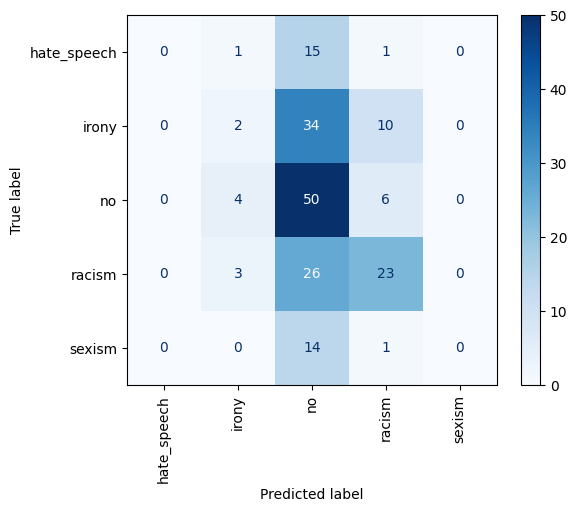

In [169]:

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Οπτικοποίηση του confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

LOGISTIC REGRESSION - WITH SMOTE

In [171]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np

# Αρχικοποίηση SMOTE για oversampling των λιγότερο εκπροσωπούμενων κατηγοριών
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Έλεγχος της νέας κατανομής των κατηγοριών
print("New class distribution:", Counter(y_resampled))

# Αρχικοποίηση Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Δημιουργία Logistic Regression μοντέλου
model = LogisticRegression(max_iter=1000)

# Υπολογισμός ακρίβειας με LOO-CV
scores = cross_val_score(model, X_resampled, y_resampled, cv=loo, scoring='accuracy')
print(f"Μέση Ακρίβεια (Logistic Regression με SMOTE - LOO-CV): {np.mean(scores):.4f}")

# --- Υπολογισμός Classification Report ---
Y_true = []
Y_pred = []

for train_index, test_index in loo.split(X_resampled):  
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]  # Χρήση slicing αντί για iloc
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]  # Pandas Series

    model.fit(X_train, y_train)  # Εκπαίδευση μοντέλου
    y_pred = model.predict(X_test)  # Πρόβλεψη

    Y_true.append(y_test.values[0])  # Μετατροπή σε απλή τιμή
    Y_pred.append(y_pred[0])  # Πρόβλεψη (NumPy array)

# Classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)


/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


New class distribution: Counter({'no': 60, 'hate_speech': 60, 'irony': 60, 'racism': 60, 'sexism': 60})
Μέση Ακρίβεια (Logistic Regression με SMOTE - LOO-CV): 0.7633
              precision    recall  f1-score   support

      racism       0.95      0.97      0.96        60
      sexism       0.69      0.57      0.62        60
       irony       0.54      0.62      0.57        60
 hate_speech       0.68      0.72      0.70        60
          no       0.98      0.95      0.97        60

    accuracy                           0.76       300
   macro avg       0.77      0.76      0.76       300
weighted avg       0.77      0.76      0.76       300



CONFUSION MATRIX - LOGISTIC REGRESSION WITH SMOTE

Confusion Matrix:
[[58  1  0  1  0]
 [ 1 34 17  8  0]
 [ 1 10 37 11  1]
 [ 1  4 12 43  0]
 [ 0  0  3  0 57]]


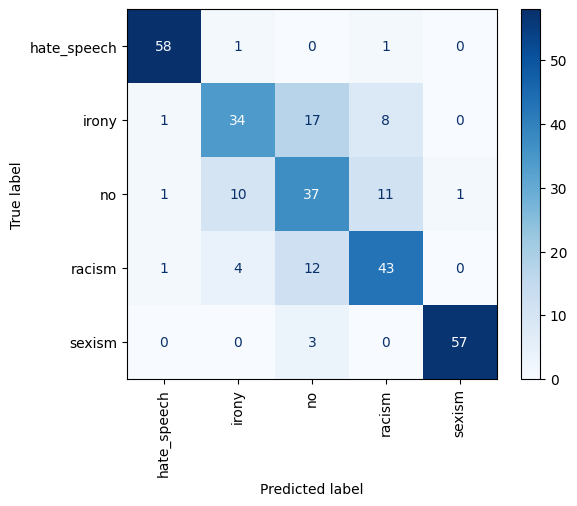

In [172]:

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Οπτικοποίηση του confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

RANDOM FOREST - SMOTE

In [175]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np

# Αρχικοποίηση SMOTE για oversampling των λιγότερο εκπροσωπούμενων κατηγοριών
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Έλεγχος της νέας κατανομής των κατηγοριών
print("New class distribution:", Counter(y_resampled))

# Αρχικοποίηση Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Δημιουργία Random Forest μοντέλου
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Υπολογισμός ακρίβειας με LOO-CV
scores = cross_val_score(model, X_resampled, y_resampled, cv=loo, scoring='accuracy')
print(f"Μέση Ακρίβεια (Random Forest με SMOTE - LOO-CV): {np.mean(scores):.4f}")

# --- Υπολογισμός Classification Report ---
Y_true = []
Y_pred = []

for train_index, test_index in loo.split(X_resampled):  
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]  # Χρήση slicing αντί για iloc
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]  # Pandas Series

    model.fit(X_train, y_train)  # Εκπαίδευση μοντέλου
    y_pred = model.predict(X_test)  # Πρόβλεψη

    Y_true.append(y_test.values[0])  # Μετατροπή σε απλή τιμή
    Y_pred.append(y_pred[0])  # Πρόβλεψη (NumPy array)

# Classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)


/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


New class distribution: Counter({'no': 60, 'hate_speech': 60, 'irony': 60, 'racism': 60, 'sexism': 60})
Μέση Ακρίβεια (Random Forest με SMOTE - LOO-CV): 0.7167
              precision    recall  f1-score   support

      racism       1.00      0.88      0.94        60
      sexism       0.85      0.38      0.53        60
       irony       0.43      0.97      0.59        60
 hate_speech       0.89      0.42      0.57        60
          no       1.00      0.93      0.97        60

    accuracy                           0.72       300
   macro avg       0.83      0.72      0.72       300
weighted avg       0.83      0.72      0.72       300



CONFUSION MATRIX - RANDOM FOREST WITH SMOTE

Confusion Matrix:
[[53  0  7  0  0]
 [ 0 23 35  2  0]
 [ 0  2 58  0  0]
 [ 0  2 33 25  0]
 [ 0  0  3  1 56]]


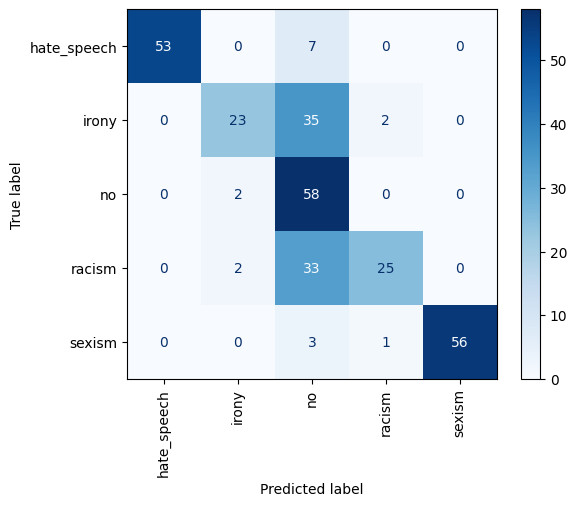

In [176]:

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Οπτικοποίηση του confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

RANDOM FOREST - NO SMOTE

In [178]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Αρχικοποίηση Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Δημιουργία Random Forest μοντέλου
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Υπολογισμός ακρίβειας με LOO-CV
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"Μέση Ακρίβεια (Random Forest χωρίς SMOTE - LOO-CV): {np.mean(scores):.4f}")

# --- Υπολογισμός Classification Report ---
Y_true = []
Y_pred = []

for train_index, test_index in loo.split(X):  
    X_train, X_test = X[train_index], X[test_index]  # Χρήση slicing αντί για iloc
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Pandas Series

    model.fit(X_train, y_train)  # Εκπαίδευση μοντέλου
    y_pred = model.predict(X_test)  # Πρόβλεψη

    Y_true.append(y_test.values[0])  # Μετατροπή σε απλή τιμή
    Y_pred.append(y_pred[0])  # Πρόβλεψη (NumPy array)

# Classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)


Μέση Ακρίβεια (Random Forest χωρίς SMOTE - LOO-CV): 0.4421
              precision    recall  f1-score   support

      racism       0.67      0.12      0.20        17
      sexism       0.43      0.07      0.11        46
       irony       0.38      0.98      0.54        60
 hate_speech       0.82      0.27      0.41        52
          no       1.00      0.40      0.57        15

    accuracy                           0.44       190
   macro avg       0.66      0.37      0.37       190
weighted avg       0.59      0.44      0.37       190



CONFUSION MATRIX - RANDOM FOREST NO SMOTE

Confusion Matrix:
[[ 2  1 14  0  0]
 [ 0  3 41  2  0]
 [ 0  1 59  0  0]
 [ 1  2 35 14  0]
 [ 0  0  8  1  6]]


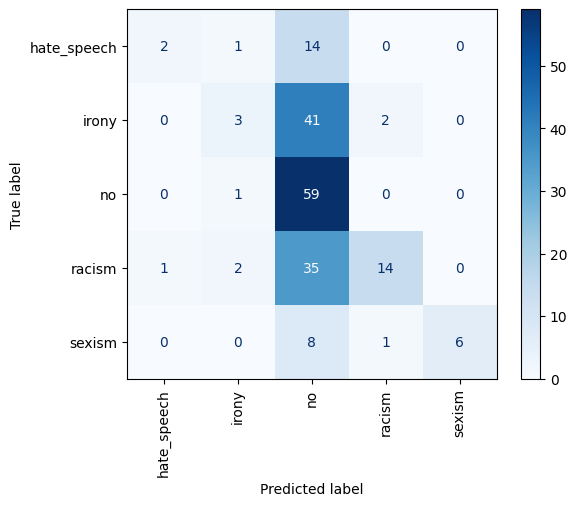

In [179]:

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Οπτικοποίηση του confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

SVM - NO SMOTE

In [181]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np

# Αρχικοποίηση Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Δημιουργία SVM μοντέλου (linear kernel)
model = SVC(kernel='linear', random_state=42)

# Υπολογισμός ακρίβειας με LOO-CV
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"Μέση Ακρίβεια (SVM χωρίς SMOTE - LOO-CV): {np.mean(scores):.4f}")

# --- Υπολογισμός Classification Report ---
Y_true = []
Y_pred = []

for train_index, test_index in loo.split(X):  
    X_train, X_test = X[train_index], X[test_index]  # Χρήση slicing αντί για iloc
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Pandas Series

    model.fit(X_train, y_train)  # Εκπαίδευση μοντέλου
    y_pred = model.predict(X_test)  # Πρόβλεψη

    Y_true.append(y_test.values[0])  # Μετατροπή σε απλή τιμή
    Y_pred.append(y_pred[0])  # Πρόβλεψη (NumPy array)

# Classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)


Μέση Ακρίβεια (SVM χωρίς SMOTE - LOO-CV): 0.4368
              precision    recall  f1-score   support

      racism       0.00      0.00      0.00        17
      sexism       0.35      0.15      0.21        46
       irony       0.38      0.75      0.51        60
 hate_speech       0.57      0.54      0.55        52
          no       1.00      0.20      0.33        15

    accuracy                           0.44       190
   macro avg       0.46      0.33      0.32       190
weighted avg       0.44      0.44      0.39       190



/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

CONFUSION MATRIX - SVM NO SMOTE

Confusion Matrix:
[[ 0  2 13  2  0]
 [ 0  7 30  9  0]
 [ 0  6 45  9  0]
 [ 0  5 19 28  0]
 [ 0  0 11  1  3]]


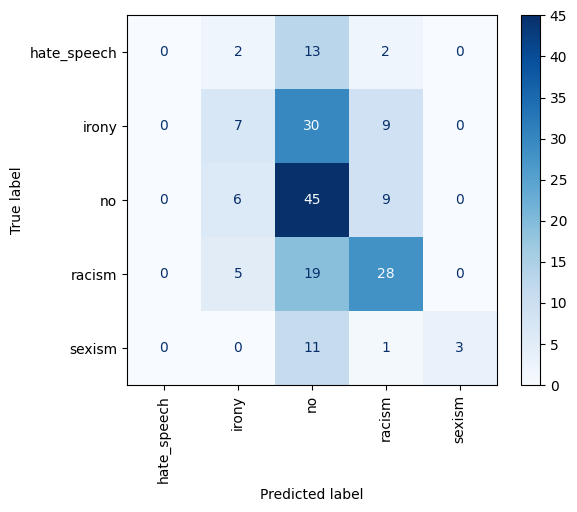

In [182]:

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Οπτικοποίηση του confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

SVM - SMOTE

In [184]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np

# Αρχικοποίηση SMOTE για oversampling των λιγότερο εκπροσωπούμενων κατηγοριών
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Έλεγχος της νέας κατανομής των κατηγοριών
print("New class distribution:", Counter(y_resampled))

# Αρχικοποίηση Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Δημιουργία SVM μοντέλου (linear kernel)
model = SVC(kernel='linear', random_state=42)

# Υπολογισμός ακρίβειας με LOO-CV
scores = cross_val_score(model, X_resampled, y_resampled, cv=loo, scoring='accuracy')
print(f"Μέση Ακρίβεια (SVM με SMOTE - LOO-CV): {np.mean(scores):.4f}")

# --- Υπολογισμός Classification Report ---
Y_true = []
Y_pred = []

for train_index, test_index in loo.split(X_resampled):  
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]  # Χρήση slicing αντί για iloc
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]  # Pandas Series

    model.fit(X_train, y_train)  # Εκπαίδευση μοντέλου
    y_pred = model.predict(X_test)  # Πρόβλεψη

    Y_true.append(y_test.values[0])  # Μετατροπή σε απλή τιμή
    Y_pred.append(y_pred[0])  # Πρόβλεψη (NumPy array)

# Classification report
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)


/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


New class distribution: Counter({'no': 60, 'hate_speech': 60, 'irony': 60, 'racism': 60, 'sexism': 60})
Μέση Ακρίβεια (SVM με SMOTE - LOO-CV): 0.7800
              precision    recall  f1-score   support

      racism       0.98      0.97      0.97        60
      sexism       0.67      0.60      0.63        60
       irony       0.56      0.65      0.60        60
 hate_speech       0.72      0.70      0.71        60
          no       1.00      0.98      0.99        60

    accuracy                           0.78       300
   macro avg       0.79      0.78      0.78       300
weighted avg       0.79      0.78      0.78       300



CONFUSION MATRIX - SVM WITH SMOTE

Confusion Matrix:
[[58  1  0  1  0]
 [ 1 36 18  5  0]
 [ 0 11 39 10  0]
 [ 0  6 12 42  0]
 [ 0  0  1  0 59]]


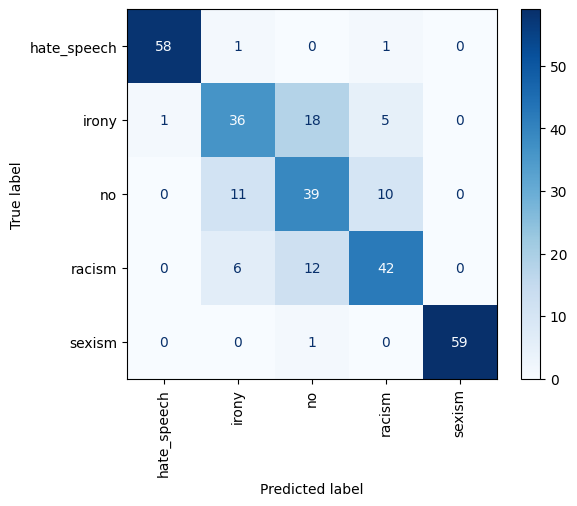

In [185]:

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Οπτικοποίηση του confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

✅ Fusion Voting μεταξύ των καλύτερων μοντέλων (SVM & Logistic Regression)
Θα εφαρμόσουμε Ensemble Learning χρησιμοποιώντας Voting Classifier.

🔹 Το Fusion Voting επιτρέπει να συνδυάσουμε τις προβλέψεις του SVM και του Logistic Regression, έτσι ώστε να παίρνουμε την τελική απόφαση με πλειοψηφία.

✅ Χρησιμοποιεί "soft" voting, που σημαίνει ότι οι πιθανότητες απόφασης λαμβάνονται υπόψη.

In [187]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np

# --- 1️⃣ Εφαρμογή SMOTE για Ισορροπία Κατηγοριών ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Έλεγχος της νέας κατανομής των κατηγοριών
print("New class distribution:", Counter(y_resampled))

# --- 2️⃣ Αρχικοποίηση Leave-One-Out Cross-Validation ---
loo = LeaveOneOut()

# --- 3️⃣ Δημιουργία των Μοντέλων ---
log_reg = LogisticRegression(max_iter=1000, random_state=42)
svm = SVC(kernel='linear', probability=True, random_state=42)  # `probability=True` για voting

# --- 4️⃣ Fusion Voting (Ensemble Learning) ---
voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg),
    ('svm', svm)
], voting='soft')  # Soft voting για καλύτερο χειρισμό των πιθανοτήτων

# --- 5️⃣ Υπολογισμός Ακρίβειας με LOO-CV ---
scores = cross_val_score(voting_clf, X_resampled, y_resampled, cv=loo, scoring='accuracy')
print(f"Μέση Ακρίβεια (Fusion Voting - LOO-CV): {np.mean(scores):.4f}")

# --- 6️⃣ Υπολογισμός Classification Report ---
Y_true = []
Y_pred = []

for train_index, test_index in loo.split(X_resampled):  
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]  # Χρήση slicing
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]  # Pandas Series

    voting_clf.fit(X_train, y_train)  # Εκπαίδευση Voting Classifier
    y_pred = voting_clf.predict(X_test)  # Πρόβλεψη

    Y_true.append(y_test.values[0])  # Μετατροπή σε απλή τιμή
    Y_pred.append(y_pred[0])  # Πρόβλεψη (NumPy array)

# --- 7️⃣ Εκτύπωση Classification Report ---
report = classification_report(Y_true, Y_pred, target_names=["racism", "sexism", "irony", "hate_speech", "no"])
print(report)


/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


New class distribution: Counter({'no': 60, 'hate_speech': 60, 'irony': 60, 'racism': 60, 'sexism': 60})
Μέση Ακρίβεια (Fusion Voting - LOO-CV): 0.7833
              precision    recall  f1-score   support

      racism       1.00      0.97      0.98        60
      sexism       0.69      0.60      0.64        60
       irony       0.55      0.70      0.62        60
 hate_speech       0.74      0.70      0.72        60
          no       1.00      0.95      0.97        60

    accuracy                           0.78       300
   macro avg       0.80      0.78      0.79       300
weighted avg       0.80      0.78      0.79       300



CONFUSION MATRIX - FUSION VOTIN SVM & LOGISTIC REGRESSION

Confusion Matrix:
[[58  1  0  1  0]
 [ 0 36 19  5  0]
 [ 0  9 42  9  0]
 [ 0  6 12 42  0]
 [ 0  0  3  0 57]]


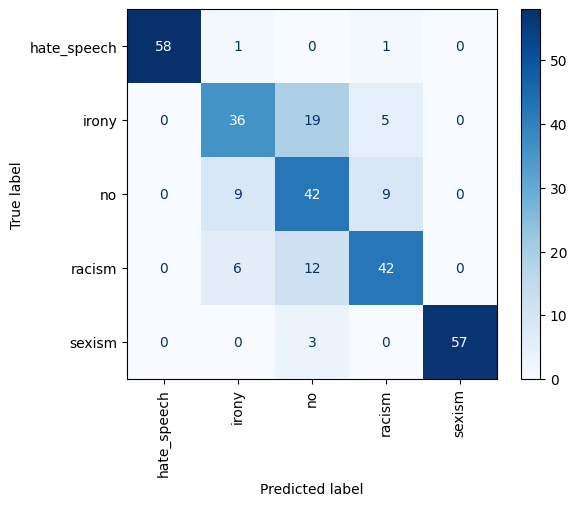

In [188]:

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

# Οπτικοποίηση του confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')